In [1]:
%matplotlib inline
%pylab
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config InlineBackend.figure_format='retina'

import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm
from Xana import Soq

from glob import glob
from Xana import CorrFunc
from Xana.Xfit.fitg2global import G2
from Xana.Xfit.fit_basic import fit_basic
from Xana.misc.add_colorbar import add_colorbar
import configparser

import pandas
import pickle
import h5py

Using matplotlib backend: <object object at 0x2b140aebc800>
Populating the interactive namespace from numpy and matplotlib


# Functions

In [1]:
def plot_ttcs(ind_xpcs, vmin=None, vmax=None):
    """ This functions plots the two-time correlation functions.
    
    Args:
        ind_xpcs (int): database index.
        vmin (float): minimum of colormap passed to imshow.
        vmax (flaot): maximum of colormap passed to imshow.
    
    """
    tmp = d.get_item(ind_xpcs)

    ttcs = tmp['twotime_corf'] # list from 0 to 20: len=21
    ttcxy = tmp['twotime_xy'] # shape (5000,)
    del tmp

    nttcs = len(ttcs.keys()) # 21: number of qs or rois
    nttcs = (nttcs // 2) * 2 # 20

    # shape qv_phi:  (21, 2)
    nq = len(np.unique(qv_phi[:nttcs,0])) # 20
    nangles = len(np.unique(qv_phi[:nttcs,1])) # 1

    condition = nq <= nangles # False

    ncols = 5
    nrows = nq // ncols #nq if condition else nangles #1

    fig, axs = plt.subplots(2, 5, figsize=(12,5), tight_layout=True)#constrained_layout=True)
    axs = np.array(axs)
    axs = np.ravel(axs.T) if condition else np.ravel(axs)

    for i, (ind, a) in enumerate(zip(ttcs.keys(), axs)):
        im = a.imshow(ttcs[ind], origin='lower', cmap='turbo', 
                      extent=[ttcxy[0], ttcxy[-1]]*2, vmin=vmin, vmax=vmax)
        q, angle = qv_phi[i]
        a.set_title(f'$q={q:.3f}\,\mathrm{{nm}}^{{-1}}$', fontsize=8)
        a.set_xlabel('$t_1\,(\mathrm{s})$', size=10)
        a.set_xlabel('$t_2\,(\mathrm{s})$', size=10)
        cb = plt.colorbar(im, ax=a, shrink=.4, aspect=50,)
        cb.ax.tick_params(labelsize=8) 
        a.minorticks_on()
        a.tick_params(which='major', labelsize=8)
    return fig


def plot_many_qs(ana, nq, nangles, qv_phi, qv, phi, rescale=False):
    """Create a plot when a setup was used with only 2 angles and several q-bins.
    """
    g = CorrFunc(ana)

    fig, axs = plt.subplots(3, 2, figsize=(6,8), constrained_layout=True, sharex='row', sharey='row')
    axs = np.array(axs).T

    angles_per_q = np.unique(qv, return_counts=True)[1]
    xf = np.logspace(-2,1,100)

    i0 = 0
    for i, (p, ax) in enumerate(zip(phi, axs)):

        a = ax[0]    
        g.get_g2(ind_xpcs, merge='merge')
        g.nq = np.where(np.isclose(qv_phi[:,1], p))[0]
        qv = qv_phi[g.nq, 0]
        if rescale:
            g.rescale(0, interval=(6,-6), norm_contrast=True)
        g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1, 
                  cmap='viridis', data='rescaled',
                  ax=a, markersize=5, method='equal',
                  init={"t0":(2, None, None)},
    #               fitglobal=['g0'],
                  fix={"a":1,})

        display(g.pars[0])

        #a.set_title(f'$\phi={p:.0f}\,\mathrm{{deg}}$')

        a = ax[1]
        angles = qv_phi[g.nq,1]
        a.errorbar(qv, 1/g.pars[0]['t0'], yerr=1/g.pars[0]['t0']**2*g.pars[0]['dt0'], fmt='o', color='tab:blue')
    #     a.set_ylim(0,10)
        a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
        a.set_ylabel(r'$\Gamma_0\,(\mathrm{s}^{-1})$')

        a = ax[2]
        angles = qv_phi[g.nq,1]
        a.errorbar(qv, g.pars[0]['g0'], yerr=g.pars[0]['dg0'], fmt='o', color='tab:red')
        a.set_ylim(0,3)
        a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
        a.set_ylabel(r'$\alpha$')

    for i, a in enumerate(axs.flatten()):
        a.minorticks_on()
        a.tick_params(which='both', right=True, top=True)
        if i//3:
            a.set_ylabel('')
            

# Measurement details

In [8]:
ls

01-xpcs-interpretation.ipynb        esrf-xpcs-Analyse.ipynb
01-xpcs-Mask-and-Analyse-old.ipynb  esrf-xpcs-ReadAnalysis.ipynb
01-xpcs-ReadAnalysis-old.ipynb      make-mask-setup.ipynb
02-saxs-analysis.ipynb              src/
02-saxs-ReadAnalysis.ipynb          trying-shit.ipynb
07-Temp-xpcs-mask-analyse.ipynb     waxs_analysis.ipynb
esrf-saxs.ipynb                     XPCS-tools/


In [5]:
d = Xana()
d.load_db('../05-analysis-powders/analysis_database.pkl')

Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/scratch_cc/MB/05-analysis-powders/analysis_database.pkl
Successfully loaded database


In [6]:
sample = 'HydLys_0p25_2'

## Select a run

In [9]:
run_series = 2
ind_xpcs = d.db[(d.db['sample'] == sample) 
           & (d.db['series']==run_series) 
           & (d.db['analysis']=='xpcs')].index.values
display(d.db.loc[ind_xpcs])

,use,sample,analysis,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir,mod,savname,savfile,setupfile,comment
20,True,HydLys_0p25_2,xpcs,2,0,0.503,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-09-05 02:59:23.977958,s0002_0020.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,
21,True,HydLys_0p25_2,xpcs,2,0,0.503,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-09-05 03:22:33.742337,s0002_0021.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,
22,True,HydLys_0p25_2,xpcs,2,0,0.503,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-09-05 03:40:27.705162,s0002_0022.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,
23,True,HydLys_0p25_2,xpcs,2,0,0.503,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-09-08 21:30:27.475183,s0002_0023.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,/asap3/petra3/gpfs/p10/2022/data/11014696/scra...,


**Specify the database entry**

In [12]:
ind_xpcs = ind_xpcs[-1]
sample = d.db.loc[ind_xpcs, 'sample']
series = d.db.loc[ind_xpcs, 'series']

### Load setup

In [13]:
detector = 'eiger4m'
setupfile = d.db.loc[ind_xpcs, 'setupfile']

d = Xana(setupfile=setupfile)
d.load_db('../05-analysis-powders/analysis_database.pkl')

Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11014696/scratch_cc/MB/02-setups/eiger4m-03-powders-02.pkl.
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/scratch_cc/MB/05-analysis-powders/analysis_database.pkl
Successfully loaded database


### Show mask and rois

In [14]:
plt.figure()
plt.imshow(d.setup.mask);

In [15]:
phi = d.setup.phiv
print(f'angles array: {phi}')
phi = phi[:,0] + phi[:,1]/2
print(f'angles vector: {phi}')
qv = d.setup.qv
print(f'q-vector: {qv}')

qv_phi = np.zeros((len(qv), 2))
qv_phi[:,0] = qv
i0 = 0
for i1 in np.unique(qv, return_counts=True)[1]:
    qv_phi[i0:i0+i1,1] = phi[:i1]
    i0 += i1

nangles = len(phi) # number of unqiue angles
nq = len(np.unique(qv)) # number of unique q-values

angles array: [[-180.  360.]]
angles vector: [0.]
q-vector: [0.005 0.025 0.045 0.065 0.085 0.105 0.125 0.145 0.165 0.185 0.205 0.225]


# Plot TTCs

<IPython.core.display.Javascript object>


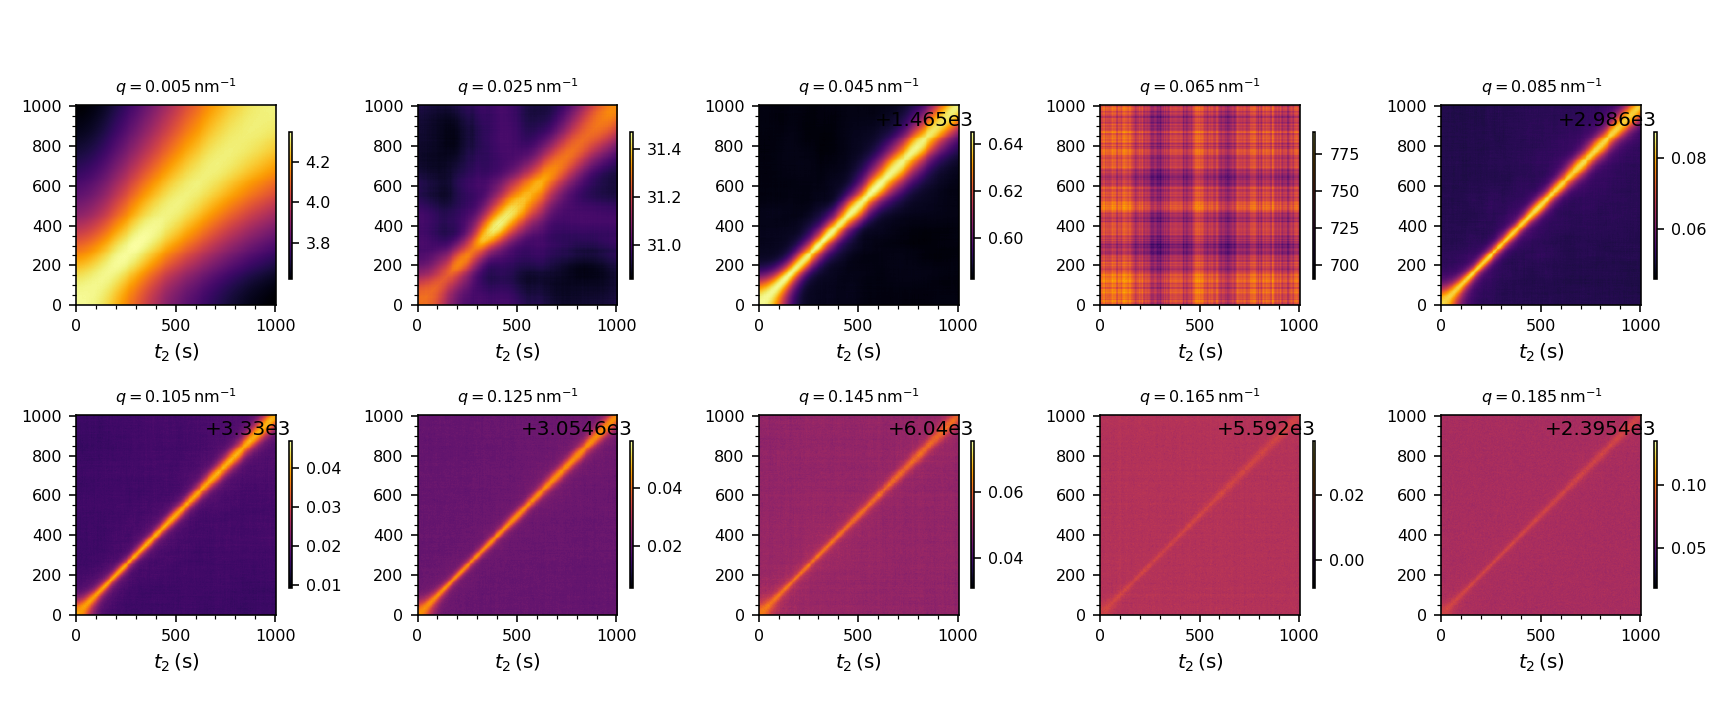

In [18]:
fig = plot_ttcs(ind_xpcs, vmin=None, vmax=None)
fig.suptitle(f"{sample}_{run_series:05}")

### Manual g2s from ttcs

In [33]:
g = CorrFunc(d)
g.get_g2(ind_xpcs)

Loaded 1 correlation functions.


(804,) (12,) (804, 12)


<IPython.core.display.Javascript object>


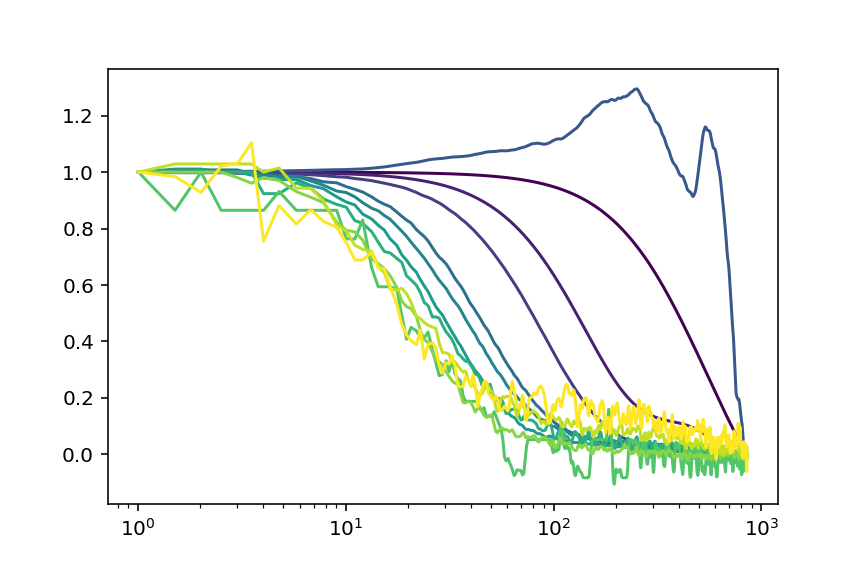

In [37]:
t = g.corrFunc[0][0][1:,0]
qv = g.corrFunc[0][0][0, 1:]
g2 = g.corrFunc[0][0][1:,1:]
print(t.shape, qv.shape, g2.shape)

plt.figure()
for q in range(len(qv)):
    y = g2[1:,q] - g2[-1,q]
    y /= y[0]
    plt.plot(t[1:], y, c=col[q])
plt.xscale('log')
plt.show()

# Plots g2s and tune the fit

In [119]:
g = CorrFunc(d)
g.get_g2(ind_xpcs, merge='merge') 

In [ ]:
# -- to rescale the g2 functions by normalizing by the contrast and subtract the baseline
# g.reset_rescaled()
# g.rescale(interval=(1, -10))
# g.rescale(normby='average', norm_contrast=False, contrast=1, baseline=1)

Merged g2 functions:  [0.5] (exposure times)
                      [1] (number of correlation functions)
                      [2000] (total number of images)


<IPython.core.display.Javascript object>


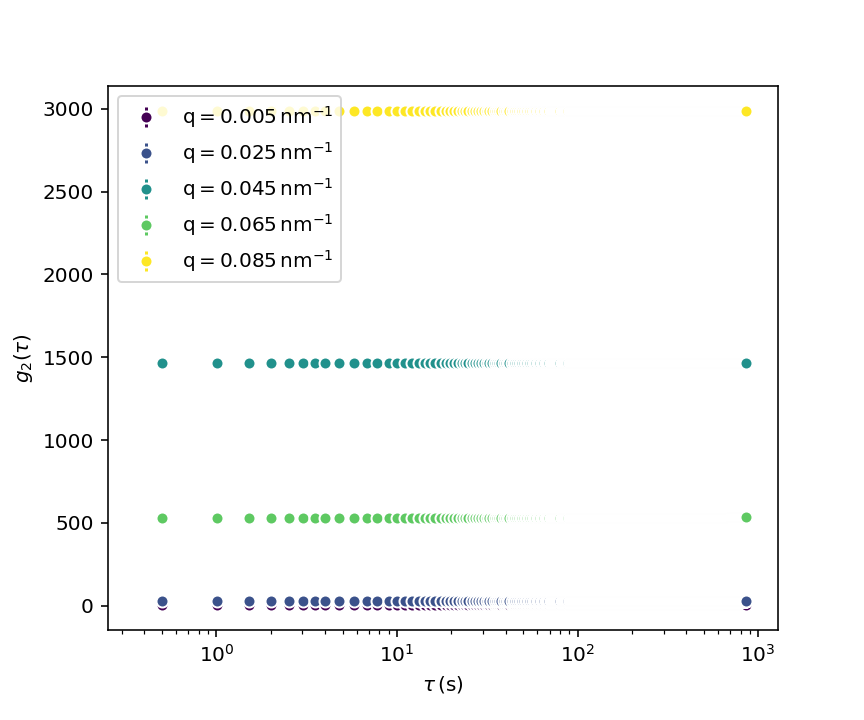

In [120]:
q_lim = 5
g.nq = np.arange(q_lim)

#g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1, 
#          fix={}, 
#          init={'t0':(t0_ini,0, None), 'g0':(1, .1, 4), 'beta':(.2, 0, 1.1)}, 
#          #fitglobal=['g0'], #,'beta' 
#          verbose=True, cmap='viridis', title=f'{sample}')

g.plot_g2(doplot='data_legq', color_mode=1, 
          dofit=0, 
          nq=np.arange(2,7,1),
          verbose=True, cmap='viridis', title=f'{sample}')

**To display fitting parameters**

In [116]:
display(g.pars[0])

,q,t0,dt0,g0,dg0,beta,dbeta,b0,db0,a,da,chisqr,redchi,bic,aic
0,0.022,118.729016,15.162958,1.172197,0.182755,0.324584,0.018558,0.324584,0.018558,1.305772,0.008936,1090.314421,0.786663,173.382943,-271.230542
1,0.032,87.652053,6.660530,1.041706,0.098420,0.320791,0.012544,0.320791,0.012544,1.167505,0.004617,1090.314421,0.786663,173.382943,-271.230542
2,0.042,67.482941,3.401171,0.973071,0.063636,0.305670,0.009120,0.305670,0.009120,1.095796,0.002661,1090.314421,0.786663,173.382943,-271.230542
3,0.052,52.365826,2.138873,0.962324,0.053733,0.283524,0.007612,0.283524,0.007612,1.058442,0.001898,1090.314421,0.786663,173.382943,-271.230542
4,0.062,46.756041,1.608347,0.928169,0.044242,0.277549,0.006722,0.277549,0.006722,1.055535,0.001508,1090.314421,0.786663,173.382943,-271.230542
5,0.072,40.933343,1.176931,0.905191,0.036953,0.260346,0.005653,0.260346,0.005653,1.038391,0.001144,1090.314421,0.786663,173.382943,-271.230542
6,0.082,36.937017,1.092024,0.859501,0.036485,0.246477,0.005942,0.246477,0.005942,1.036440,0.001054,1090.314421,0.786663,173.382943,-271.230542
7,0.092,34.103163,0.910254,0.842906,0.033051,0.229675,0.005312,0.229675,0.005312,1.026706,0.000858,1090.314421,0.786663,173.382943,-271.230542
8,0.102,31.708392,0.970293,0.770660,0.034846,0.219682,0.006450,0.219682,0.006450,1.024500,0.000842,1090.314421,0.786663,173.382943,-271.230542
9,0.112,29.878297,0.990335,0.731834,0.036116,0.213788,0.007362,0.213788,0.007362,1.021729,0.000810,1090.314421,0.786663,173.382943,-271.230542


In [117]:
fit_par = g.pars[0]
fit_par.columns

Index(['q', 't0', 'dt0', 'g0', 'dg0', 'beta', 'dbeta', 'b0', 'db0', 'a', 'da',
       'chisqr', 'redchi', 'bic', 'aic'],
      dtype='object')